In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
%matplotlib inline
tf.__version__

'2.0.0'

In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
# fmnist = tf.keras.datasets.fashion_mnist
# (fx_train, fy_train), (fx_test, fy_test) = fmnist.load_data()

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
def show_random_numbers(data):
    fig2 = plt.figure(constrained_layout=True, figsize=(12, 3))
    cols, rows = 10, 2
    items = data[np.random.choice(np.arange(data.shape[0]), cols*rows)]
    spec2 = gridspec.GridSpec(ncols=cols, nrows=rows, figure=fig2)
    for idx, d in enumerate(items):
        ax = fig2.add_subplot(spec2[idx // cols, idx % cols])
        plt.imshow(d)
        plt.axis('off')

In [6]:
def show_numbers(data):
    fig2 = plt.figure(constrained_layout=True, figsize=(12, 3))
    cols, rows = 10, 2
    items = data[:cols*rows]
    spec2 = gridspec.GridSpec(ncols=cols, nrows=rows, figure=fig2)
    for idx, d in enumerate(items):
        ax = fig2.add_subplot(spec2[idx // cols, idx % cols])
        plt.imshow(d)
        plt.axis('off')

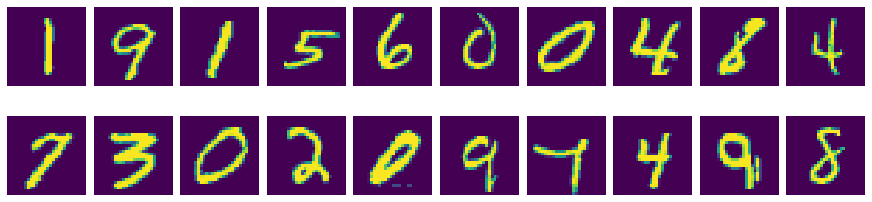

In [7]:
show_random_numbers(x_train)

In [8]:
from nnbinary import NNBinary

In [9]:
def acc(model, x, y):
    return np.sum(model.predict(x) == y) / y.shape[0]

In [10]:
def accTotal(f, x, y):
    return np.sum(f(x) == y) / y.shape[0]

In [11]:
def train_one_vs_rest(x, trg, r, eta=0.0001, eps=1.e-6, seed=None):
    models = [NNBinary(r) for _ in range(10)]
    for digi, model in enumerate(models):
        print('learn digit {} ...'.format(digi))
        y = np.array(trg == digi, dtype=int).reshape(-1, 1)
        while not model.train(x, y, eta=eta, batch=100, eps=eps):
            pass
        print('Acc reached: {:.2f}'.format(acc(model, x, y)))
    return (lambda x: np.argmax([m.forward(x)[-1] for m in models], axis=0), models)

In [12]:
N = x_train.shape[0]
x0_train = x_train[:N].reshape(N, -1) / 255.
y0_train = y_train[:N].reshape(N, 1)
x0_test = x_test.reshape(x_test.shape[0], -1) / 255.
y0_test = y_test.reshape(y_test.shape[0], 1)

In [13]:
x0_train.shape

(60000, 784)

In [14]:
def save_model(fname, models):
    for digi, model in enumerate(models):
        model.toFile(fname + str(digi))

def load_model(fname):
    models = [NNBinary() for _ in range(10)]
    for digi, model in enumerate(models):
        model.fromFile(fname + str(digi) + '.npy')
    return (lambda x: np.argmax([m.forward(x)[-1] for m in models], axis=0), models)

In [15]:
fname = 'data/binary60k'

In [16]:
# %%time
# f, models = train_one_vs_rest(x0_train, y0_train, r=[32], eps=1.e-4)
# save_model(fname, models)

In [17]:
f, models = load_model(fname)

In [18]:
f(x0_train[:20]).reshape(2,-1)

array([[5, 0, 4, 1, 9, 2, 1, 3, 1, 4],
       [3, 5, 3, 6, 1, 7, 2, 8, 6, 9]])

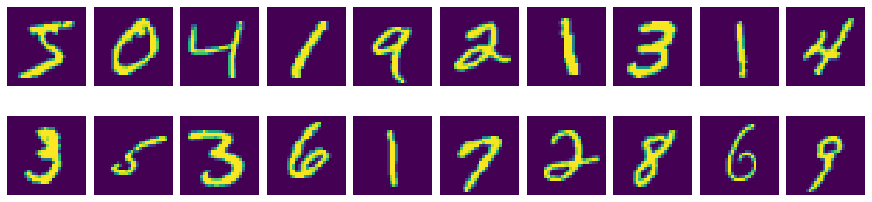

In [19]:
show_numbers(x_train)

In [20]:
f(x0_test[:20]).reshape(2,-1)

array([[7, 2, 1, 0, 4, 1, 4, 9, 6, 9],
       [0, 6, 9, 0, 1, 5, 9, 7, 8, 4]])

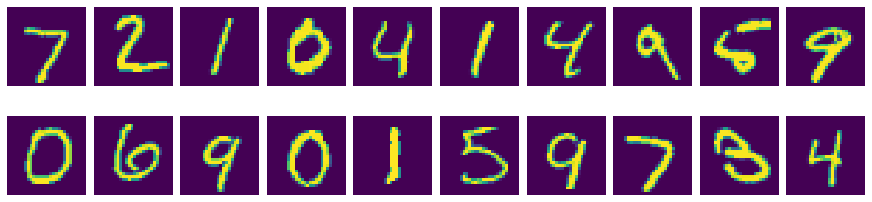

In [21]:
show_numbers(x_test)

In [22]:
accTotal(f, x0_train, y0_train)

0.9988333333333334

In [23]:
accTotal(f, x0_test, y0_test)

0.9757

# Tensorflow: Keras sequential dense

In [24]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
xtf_train, xtf_test = x_train / 255., x_test / 255.

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.995:
            print('\nReached 99% accuracy. Finishing training')
            self.model.stop_training = True

In [27]:
model.fit(xtf_train, y_train,
          epochs=20, batch_size=100,
          callbacks=[myCallback()],
          validation_data=(xtf_test, y_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 50us/sample - loss: 0.3402 - accuracy: 0.9079 - val_loss: 0.1843 - val_accuracy: 0.9475
Epoch 2/20
60000/60000 [==============================] - 2s 33us/sample - loss: 0.1570 - accuracy: 0.9551 - val_loss: 0.1360 - val_accuracy: 0.9594
Epoch 3/20
60000/60000 [==============================] - 2s 35us/sample - loss: 0.1126 - accuracy: 0.9676 - val_loss: 0.1046 - val_accuracy: 0.9674
Epoch 4/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0865 - accuracy: 0.9744 - val_loss: 0.0932 - val_accuracy: 0.9720
Epoch 5/20
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0695 - accuracy: 0.9798 - val_loss: 0.0837 - val_accuracy: 0.9751
Epoch 6/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0578 - accuracy: 0.9833 - val_loss: 0.0800 - val_accuracy: 0.9766
Epoch 7/20
60000/60000 [==============================] 

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  100480    
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [29]:
# with open('tf_seq.json', 'w') as json_file:
#     json_file.write(model.to_json())
# model.save_weights('tf_seq_wgh.h5')

In [30]:
# model = tf.keras.model_from_json('tf_seq.json')
# model.load_wights('tf_seq_wgh.h5')

In [31]:
# model.predict(xtf_train)
model.evaluate(xtf_train, y_train, verbose=0)

[0.01700055979438281, 0.9959]

In [32]:
model.evaluate(xtf_test, y_test, verbose=0)

[0.0790202908373205, 0.9764]

# Tensorflow: Keras sequential convolution

In [33]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [34]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
xtf_train = x_train.reshape(-1, 28, 28, 1) / 255.
xtf_test = x_test.reshape(-1, 28, 28, 1) / 255.

In [35]:
model.fit(xtf_train, y_train,
          epochs=20, batch_size=100,
          callbacks=[myCallback()],
          validation_data=(xtf_test, y_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 16s 269us/sample - loss: 0.2783 - accuracy: 0.9173 - val_loss: 0.0853 - val_accuracy: 0.9730
Epoch 2/20
60000/60000 [==============================] - 15s 258us/sample - loss: 0.0860 - accuracy: 0.9732 - val_loss: 0.0656 - val_accuracy: 0.9786
Epoch 3/20
60000/60000 [==============================] - 17s 283us/sample - loss: 0.0618 - accuracy: 0.9808 - val_loss: 0.0554 - val_accuracy: 0.9828
Epoch 4/20
60000/60000 [==============================] - 16s 268us/sample - loss: 0.0490 - accuracy: 0.9849 - val_loss: 0.0419 - val_accuracy: 0.9855
Epoch 5/20
60000/60000 [==============================] - 16s 271us/sample - loss: 0.0398 - accuracy: 0.9880 - val_loss: 0.0409 - val_accuracy: 0.9871
Epoch 6/20
60000/60000 [==============================] - 16s 265us/sample - loss: 0.0353 - accuracy: 0.9887 - val_loss: 0.0394 - val_accuracy: 0.9868
Epoch 7/20
60000/60000 [====================

In [36]:
with open('tf_cnn.json', 'w') as json_file:
    json_file.write(model.to_json())
model.save_weights('tf_cnn_wgh.h5')

In [37]:
# model = tf.keras.models.model_from_json('tf_cnn.json')
# model.load_weights('tf_cnn_wgh.h5')

In [38]:
model.evaluate(xtf_train, y_train, verbose=0)

[0.009626780199747494, 0.99723333]

In [39]:
model.evaluate(xtf_test, y_test, verbose=0)

[0.036906356185791085, 0.9883]